# Project Business Statistics: E-News Express

### Business Context

The advent of e-news, or electronic news, portals have offered us a great opportunity to quickly get updates on the day-to-day events occurring globally. The information on these portals is retrieved electronically from online databases, processed using a variety of software, and then transmitted to the users. There are multiple advantages of transmitting new electronically, like faster access to the content and the ability to utilize different technologies such as audio, graphics, video, and other interactive elements that are either not being used or aren’t common yet in traditional newspapers.

E-news Express, an online news portal, aims to expand its business by acquiring new subscribers. With every visitor to the website taking certain actions based on their interest, the company plans to analyze these actions to understand user interests and determine how to drive better engagement.  The executives at E-news Express are of the opinion that there has been a decline in new monthly subscribers compared to the past year because the current webpage is not designed well enough in terms of the outline & recommended content to keep customers engaged long enough to make a decision to subscribe.

[Companies often analyze user responses to two variants of a product to decide which of the two variants is more effective. This experimental technique, known as A/B testing, is used to determine whether a new feature attracts users based on a chosen metric.]


### Objective

The design team of the company has researched and created a new landing page that has a new outline & more relevant content shown compared to the old page. In order to test the effectiveness of the new landing page in gathering new subscribers, the Data Science team conducted an experiment by randomly selecting 100 users and dividing them equally into two groups. The existing landing page was served to the first group (control group) and the new landing page to the second group (treatment group). Data regarding the interaction of users in both groups with the two versions of the landing page was collected. Being a data scientist in E-news Express, you have been asked to explore the data and perform a statistical analysis (at a significance level of 5%) to determine the effectiveness of the new landing page in gathering new subscribers for the news portal by answering the following questions:

1. Do the users spend more time on the new landing page than on the existing landing page?

2. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

3. Does the converted status depend on the preferred language? [Hint: Create a contingency table using the pandas.crosstab() function]

4. Is the time spent on the new page the same for the different language users?


### Data Dictionary

The data contains information regarding the interaction of users in both groups with the two versions of the landing page.

1. user_id - Unique user ID of the person visiting the website

2. group - Whether the user belongs to the first group (control) or the second group (treatment)

3. landing_page - Whether the landing page is new or old

4. time_spent_on_the_page - Time (in minutes) spent by the user on the landing page

5. converted - Whether the user gets converted to a subscriber of the news portal or not

6. language_preferred - Language chosen by the user to view the landing page

## Import the necessary libraries

In [190]:
# Libraries to help with reading and manipulating data
import pandas as pd
import numpy as np

# Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Library to help with statistical analysis
import scipy.stats as stats

import pprint

##### User defined function

In [191]:
def basic_dataframe_info(df):

  # view a few rows of the data frame
  print(f"1. First few rows of dataset", end='\n\n', sep='\n\n');
  display(df.head())

  # view a last rows of the data frame
  print(f"\n\n2. Last few rows of dataset", end='\n\n', sep='\n\n');
  display(df.tail())

  # view the shape of the data frame
  print("\n\n3. There are {0} rows and {1} columns in the dataframe".format(df.shape[0],df.shape[1]))

  # check the data types of the columns in the data frame
  print(f"\n\n4. Data types of the columns", end='\n\n', sep='\n\n');
  display(df.dtypes)

  ### Check for missing values
  # missing value check
  print(f"\n\n5. Missing values in columns", end='\n\n', sep='\n\n');
  print(df.isna().sum())

  #Find Unique values and their count
  unique_counts = pd.DataFrame.from_records([(col, df[col].nunique(),df[col].unique().tolist()) for col in df.select_dtypes(exclude=['int64','float64']).columns],
                          columns=['Column Name', 'Unique Count', 'Unique Value',]).sort_values(by=['Unique Count'])
  print(f"\n\n6. Unique values and their count", end='\n\n', sep='\n\n');
  display(unique_counts)

  #Find  values and their count/frequency of categorical variable
  category_cols= df.select_dtypes(exclude=['int64','float64']).columns.tolist()
  print(f"\n\n7. Frequency of categorical variable", end='\n\n', sep='\n\n');
  display(pd.DataFrame(
    df[category_cols]
    .melt(var_name='Category Type column', value_name='value')
    .value_counts())
.rename(columns={0: 'count'})
.sort_values(by=['Category Type column']))

  #Check for duplicate values
  #df.duplicated().sum()
  print(f"\n\n8. There are {0} duplicated values",df.duplicated().sum(),  end='\n\n', sep='\n\n');
  #display(category_cols)

 # Getting the statistical summary for the numerical variables
  print(f"\n\n9. Statistical summary of numerical variables", end='\n\n', sep='\n\n');
  display(df.describe().T)
  # Getting the statistical summary for the catgorical variables
  print(f"\n\n10. Statistical summary of catgorical variables", end='\n\n', sep='\n\n');
  display(df.describe(include = ['object']).T)

## Memory usage
def memory_usage_before_after(df):
  #Memory usage before group,landing_page,converted and language_preferred is converted to category type
  print("Memory usage before group,landing_page,converted and language_preferred is converted to category type")
  print("-" * 105)

  print(df.memory_usage(deep=True))
  print("Total Memory usage:", df.memory_usage().sum())


  df[['group', 'landing_page', 'converted','language_preferred']]= df[['group', 'landing_page', 'converted','language_preferred']]\
.apply(lambda x: x.astype('category'))
  df.dtypes

  #Memory usage after group,landing_page,converted and language_preferred is converted to category type
  print("\n\nMemory usage after group,landing_page,converted and language_preferred is converted to category type")
  print("-" * 105)
  print(df.memory_usage(deep=True))
  print("Total Memory usage:", df.memory_usage().sum())

#### Univariate Analysis UDF

In [192]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to show the density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram
# function to create labeled barplots


def labeled_barplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 5))
    else:
        plt.figure(figsize=(n + 1, 5))

    plt.xticks(rotation=90, fontsize=10)
    ax = sns.countplot(data=data, x=feature, palette="Paired", hue=feature, order=data[feature].value_counts().index[:n].sort_values())
    sns.despine();
    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(100 * p.get_height() / total)  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()      # height of the plot

        ax.annotate(label, (x, y), ha="center", va="center", size=10, xytext=(0, 5), textcoords="offset points")  # annotate the percentage

    plt.show()  # show the plot

### 1. Explore the dataset and extract insights using Exploratory Data Analysis.
**Exploratory Data Analysis - Step by step approach.**

Typical Data exploration activity consists of the following steps:

1. Importing Data
2. Variable Identification
3. Variable Transformation/Feature Creation
4. Missing value detection
5. Univariate Analysis
6. Bivariate Analysis


#### Loading the dataset

In [193]:
df = pd.read_csv('/content/sample_data/abtest.csv')

In [194]:
basic_dataframe_info(df)

1. First few rows of dataset



,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
0,546592,control,old,3.48,no,Spanish
1,546468,treatment,new,7.13,yes,English
2,546462,treatment,new,4.40,no,Spanish
3,546567,control,old,3.02,no,French
4,546459,treatment,new,4.75,yes,Spanish




2. Last few rows of dataset



,user_id,group,landing_page,time_spent_on_the_page,converted,language_preferred
95,546446,treatment,new,5.15,no,Spanish
96,546544,control,old,6.52,yes,English
97,546472,treatment,new,7.07,yes,Spanish
98,546481,treatment,new,6.20,yes,Spanish
99,546483,treatment,new,5.86,yes,English




3. There are 100 rows and 6 columns in the dataframe


4. Data types of the columns



,0
user_id,int64
group,object
landing_page,object
time_spent_on_the_page,float64
converted,object
language_preferred,object




5. Missing values in columns

user_id                   0
group                     0
landing_page              0
time_spent_on_the_page    0
converted                 0
language_preferred        0
dtype: int64


6. Unique values and their count



,Column Name,Unique Count,Unique Value
0,group,2,"[control, treatment]"
1,landing_page,2,"[old, new]"
2,converted,2,"[no, yes]"
3,language_preferred,3,"[Spanish, English, French]"




7. Frequency of categorical variable



count
Category Type column value           
converted            yes           54
                     no            46
group                control       50
                     treatment     50
landing_page         old           50
                     new           50
language_preferred   French        34
                     Spanish       34
                     English       32



8. There are 0 duplicated values

0



9. Statistical summary of numerical variables



,count,mean,std,min,25%,50%,75%,max
user_id,100.0,546517.0000,52.295779,546443.00,546467.75,546492.500,546567.2500,546592.00
time_spent_on_the_page,100.0,5.3778,2.378166,0.19,3.88,5.415,7.0225,10.71




10. Statistical summary of catgorical variables



,count,unique,top,freq
group,100,2,control,50
landing_page,100,2,old,50
converted,100,2,yes,54
language_preferred,100,3,Spanish,34


**Observations:**

- It can be observed that except `user_id` and `time_spent_on_the_page`, rest all the variables are categorical in nature
* The dataset has 100 rows and 6 columns.
- The `group`,`landing_page`,`converted`,`langauage_preferred` are object type. We have to convert it to category type for performance

- convert the group,landing_page,converted and language_preferred to categorical types for less memory usage

-  There are no missing values in any of the columns

-  There are no duplicate values in any of the columns

* The maximum time spent on the landing page is less than 11 minutes.
* The mean time spent on the landing page is approximately 5.4 minutes.
* The median time spent on the landing page is approximately 5.4 minutes.

- Variables `group`, `landing_page` and `converted` have only two categories
- It can be observed that the distribution of users in `group` and `landing_page` are equal
- More than 50% of users are converted
- There are three categories of languages preferred by users, among which Spanish has been preferred the most by users.

**Memory usage before  and after group,landing_page,converted and language_preferred is converted to category type**

In [195]:
memory_usage_before_after(df)

Memory usage before group,landing_page,converted and language_preferred is converted to category type
---------------------------------------------------------------------------------------------------------
Index                      132
user_id                    800
group                     6500
landing_page              6000
time_spent_on_the_page     800
converted                 5954
language_preferred        6366
dtype: int64
Total Memory usage: 4932


Memory usage after group,landing_page,converted and language_preferred is converted to category type
---------------------------------------------------------------------------------------------------------
Index                     132
user_id                   800
group                     338
landing_page              328
time_spent_on_the_page    800
converted                 327
language_preferred        399
dtype: int64
Total Memory usage: 2636


**Observations:**

- The total memory usage is 4932 bytes before converting the object type to category type
- The total memory usage is 2636 bytes after converting the object type to category type

In [196]:
print(f"\n\n - Time spent on the page by group", end='\n\n', sep='\n\n');
display(df.groupby('group')['time_spent_on_the_page'].describe())
print(f"\n\n Time spent on the page by landing page", end='\n\n', sep='\n\n');
display(df.groupby('landing_page')['time_spent_on_the_page'].describe())
print(f"\n\n Time spent on the page by converted", end='\n\n', sep='\n\n');
display(df.groupby('converted')['time_spent_on_the_page'].describe())
print(f"\n\n Time spent on the page by language_preferred", end='\n\n', sep='\n\n');
display(df.groupby('language_preferred')['time_spent_on_the_page'].describe())



 - Time spent on the page by group



/tmp/ipython-input-196-2117871350.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('group')['time_spent_on_the_page'].describe())


,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
control,50.0,4.5324,2.581975,0.19,2.720,4.380,6.4425,10.30
treatment,50.0,6.2232,1.817031,1.65,5.175,6.105,7.1600,10.71




 Time spent on the page by landing page



/tmp/ipython-input-196-2117871350.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('landing_page')['time_spent_on_the_page'].describe())


,count,mean,std,min,25%,50%,75%,max
landing_page,,,,,,,,
new,50.0,6.2232,1.817031,1.65,5.175,6.105,7.1600,10.71
old,50.0,4.5324,2.581975,0.19,2.720,4.380,6.4425,10.30




 Time spent on the page by converted



/tmp/ipython-input-196-2117871350.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('converted')['time_spent_on_the_page'].describe())


,count,mean,std,min,25%,50%,75%,max
converted,,,,,,,,
no,46.0,3.915870,2.226897,0.19,2.3375,3.980,4.9225,9.15
yes,54.0,6.623148,1.708427,2.58,5.5000,6.495,7.3675,10.71




 Time spent on the page by language_preferred



/tmp/ipython-input-196-2117871350.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(df.groupby('language_preferred')['time_spent_on_the_page'].describe())


,count,mean,std,min,25%,50%,75%,max
language_preferred,,,,,,,,
English,32.0,5.559062,2.621079,0.22,3.6175,5.755,7.1375,10.50
French,34.0,5.253235,2.675413,0.40,3.3950,5.315,7.3675,10.71
Spanish,34.0,5.331765,1.818095,0.19,4.4750,5.605,6.5150,8.72


**Observations:**

- There are 100 unique users.
- There are 2 unique groups - control and treatment. Each group consists of 50 users.
- There are 2 landing_pages - new and old.
- Overall, 54 users get converted and 46 users do not get converted after visiting the landing page.
- There are 3 unique preferred languages - English, French, and Spanish.
- There are no missing and duplicate records
- The total memory usage before converting the object data type to categorical type is 4928 bytes and after converting to category type it is is 2632 bytes.
- The memory usuage of group ,landing_page, converted, language_preferred reduced ~20 times by converting object to category type
- The data contains information about 2 groups( control and treatment) which a count of 50 each
- The average time spent on a new landing page is ~6.22 minutes and for old landing page is ~4.53 minutes. This means more time is spent on new landing page

## Exploratory Data Analysis

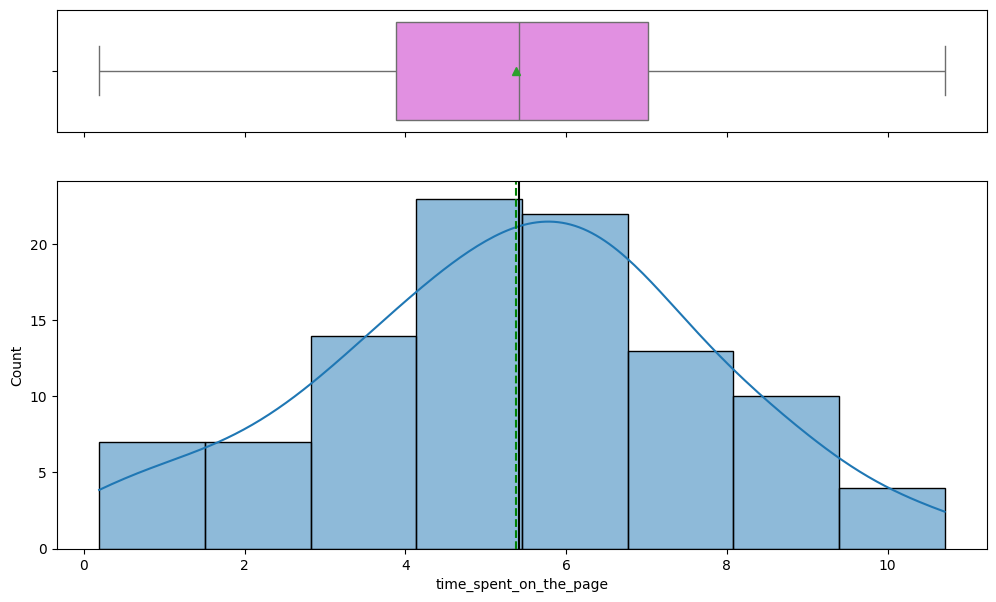

In [197]:
histogram_boxplot(df,"time_spent_on_the_page",kde="True")

* The time spent on the page seems to have a fairly normal distribution.
* There are no outliers in this column.

Let us now explore the categorical variables

#### Group

In [198]:
df['group'].value_counts()

,count
group,
control,50
treatment,50


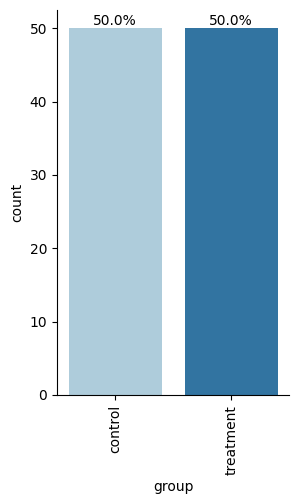

In [199]:
labeled_barplot(df, 'group', perc=True)

**Observations:**

*  There are 2 unique group in the dataset.
* The distribution of the number of users across the two groups are the same

#### Landing page

In [200]:
df['landing_page'].value_counts()

,count
landing_page,
new,50
old,50


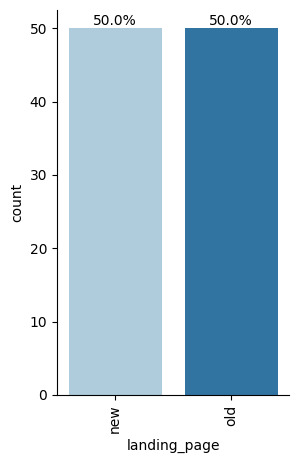

In [201]:
labeled_barplot(df, 'landing_page', perc=True)

**Observations:**

* The distribution of the number of users across the two landing pages are the same.

#### Converted

In [202]:
df['converted'].value_counts()

,count
converted,
yes,54
no,46


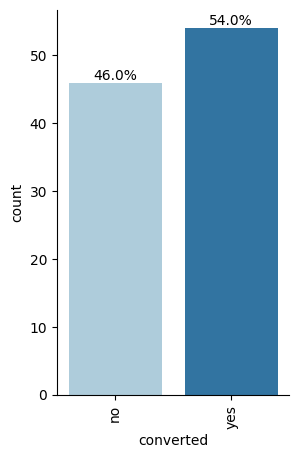

In [203]:
labeled_barplot(df, 'converted', perc=True)

**Observations:**
- Overall, 54 users get converted and 46 users do not get converted after visiting the landing page

#### Preferred language

In [204]:
df['language_preferred'].value_counts()

,count
language_preferred,
French,34
Spanish,34
English,32


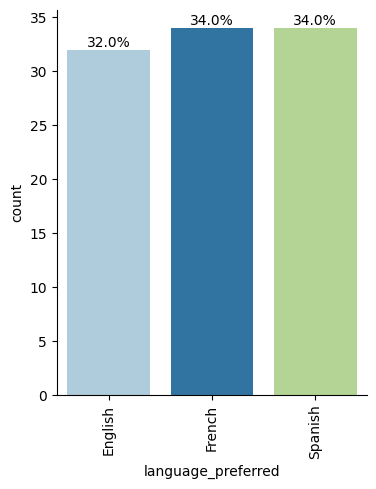

In [205]:
# check unique prefered language
#df['language_preferred'].value_counts().shape
labeled_barplot(df, 'language_preferred', perc=True)

- The distribution of the number of users across various preferred languages is fairly uniform
- There are 3 unique preferred languages - English, French, and Spanish.
<br> Spanish and French both have been equally and mostly preferred by users

In [451]:
def hist_box_point_plot(data, x_feature, y_feature):
  fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=False)
  sns.set_style('whitegrid')
  plt.subplot(1, 3, 1)
  ax=sns.histplot(data = df, x = y_feature, hue = x_feature,kde="True")
  for c in ax.containers:
      # set the bar label
      ax.bar_label(c)

  plt.subplot(1, 3, 2)
  sns.boxplot(x = x_feature, y = y_feature, hue = x_feature, data = df, palette = 'PuBu',orient="v",showmeans=True)
  plt.xticks(rotation = 45)


  plt.subplot(1, 3, 3)
  #sns.set_theme(style="darkgrid")
  ax1=sns.pointplot(x = x_feature, y = y_feature, data = df,estimator=np.median)
  for a in ax1.get_xticklabels():
      a.set_rotation(45)
  for c in  ax1.collections:
      for of in c.get_offsets():
          ax1.annotate(of[1], of, ha='right')


  plt.tight_layout(w_pad=5)
  plt.show()
  sns.despine();

### Bivariate Analysis

#### Landing page vs Time spent on the page

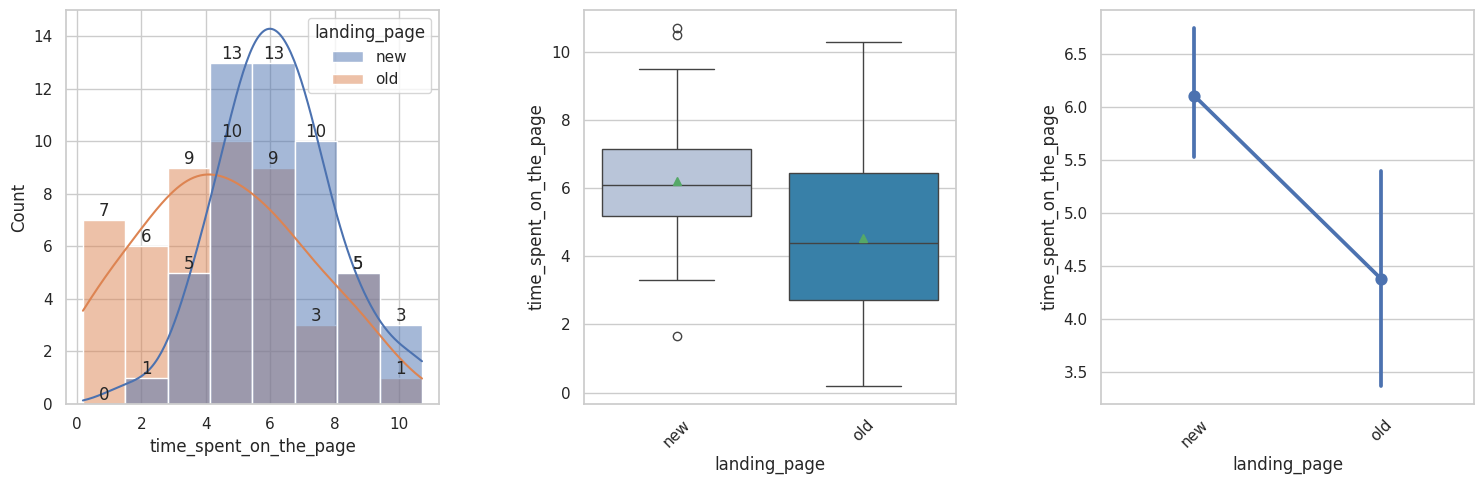

<Figure size 640x480 with 0 Axes>

In [452]:
hist_box_point_plot(df,'landing_page','time_spent_on_the_page')

* Overall, the time spent on the new page seems to be greater than the time spent on the old page.
* The time spent on old page is right skewed and new page is almost normally distributed


#### Conversion status vs Time spent on the page

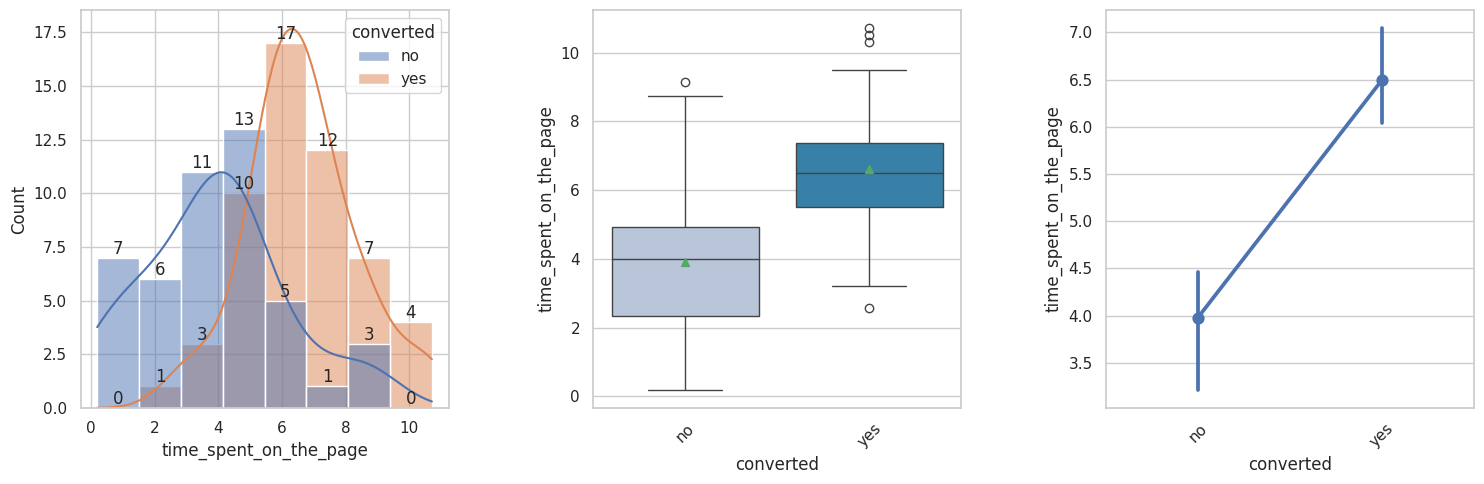

<Figure size 640x480 with 0 Axes>

In [453]:
hist_box_point_plot(df,'converted','time_spent_on_the_page')

* Overall, the users who get converted seem to spend more time on the page.

#### Preferred language vs Time spent on the page

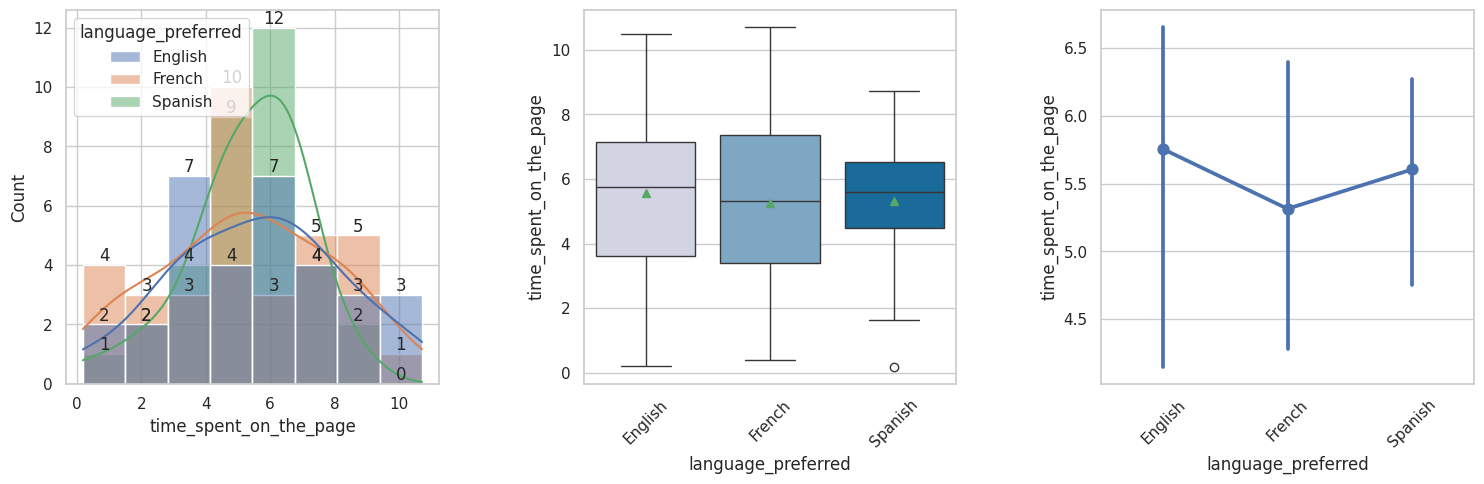

<Figure size 640x480 with 0 Axes>

In [454]:
hist_box_point_plot(df,'language_preferred','time_spent_on_the_page')

* The median time spent by the different language users are approximately equal.
* The mean time spent by the different language users are approximately equal.

## 1. Do the users spend more time on the new landing page than the existing landing page?

### Perform Visual Analysis

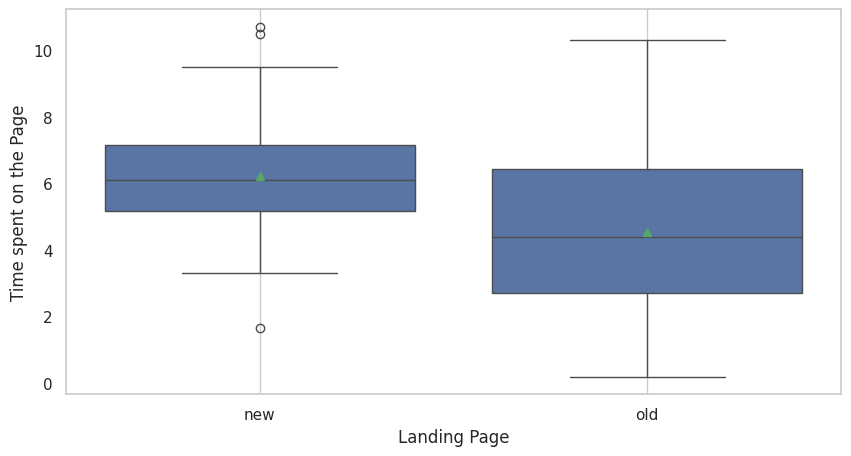

In [459]:
# visual analysis of the time spent on the new page
# and the time spent on the old page
plt.figure(figsize=(10,5))
sns.boxplot(x = 'landing_page', y = 'time_spent_on_the_page', data = df, showmeans=True)
plt.ylabel("Time spent on the Page")
plt.xlabel("Landing Page")
plt.grid()
plt.show()

* We see that people spent more time on the new page than the old landing page

### Step 1: Define the null and alternative hypotheses

> $H_0:$ The mean time spent by the users on the new page is equal to the mean time spent by the users on the old page. <br>
$H_a:$ The mean time spent by the users on the new page is greater than the mean time spent by the users on the old page.

Let $\mu_1$ and $\mu_2$ be the mean time spent by the users on the new and old page respectively. Then the above formulated hypotheses can be mathematically written as:

> $H_0: \mu_1 = \mu_2 \\
H_a: \mu_1 > \mu_2$

### Step 2: Select Appropriate test

This is a one-tailed test concerning two population means from two independent populations. As the population standard deviations are unknown, the two sample independent t-test will be the appropriate test for this problem.

### Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05.

### Step 4: Collect and prepare data

In [461]:
# create subsetted data frame for new landing page users
time_spent_new = df[df['landing_page'] == 'new']['time_spent_on_the_page']
# create subsetted data frame for old landing page users
time_spent_old = df[df['landing_page'] == 'old']['time_spent_on_the_page']

# find the sample means and sample standard deviations for the two samples
print('The mean time spent on  the new landing page is ' + str(time_spent_new.mean()))
print('The mean time spent on  the old landing page is ' + str(time_spent_old.mean()))

print('The sample standard deviation of the time spent on the new page is:', round(time_spent_new.std(),2))
print('The sample standard deviation of the time spent on the new page is:', round(time_spent_old.std(),2))

The mean time spent on  the new landing page is 6.2232
The mean time spent on  the old landing page is 4.532400000000001
The sample standard deviation of the time spent on the new page is: 1.82
The sample standard deviation of the time spent on the new page is: 2.58


**Let's test whether the T-test assumptions are satisfied or not**

* Continuous data - Yes, the time spent on new and old page is measured on a continuous scale.
* Normally distributed populations - Yes, we are informed that the populations are assumed to be normal.
* Independent populations - As we are taking random samples for two different groups, the two samples are from two independent populations.
* Unequal population standard deviations - As the sample standard deviations are different, the population standard deviations may be assumed to be different.
* Random sampling from the population - Yes, we are informed that the collected sample a simple random sample.

### Step 5: Calculate the p-value

In [462]:
from scipy.stats import ttest_ind
test_stat, p_value =   ttest_ind(time_spent_new, time_spent_old, equal_var=False, alternative='greater')
print('The p-value is', p_value)

The p-value is 0.0001392381225166549


### Step 6: Compare the p-value with $\alpha$

In [463]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.0001392381225166549 is less than the level of significance, we reject the null hypothesis.


### Step 7:  Draw inference

Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the mean time spent by the users on the new page is greater than the mean time spent by the users on the old page.

## 2. Is the conversion rate (the proportion of users who visit the landing page and get converted) for the new page greater than the conversion rate for the old page?

### Perform Visual Analysis

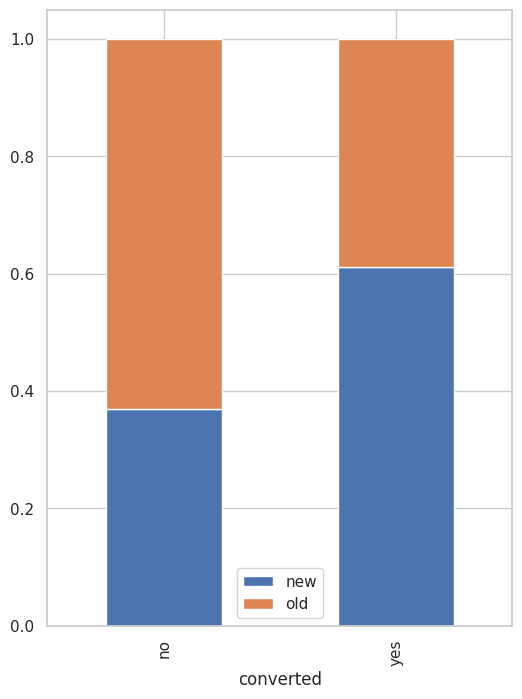

In [468]:
# visual analysis of the conversion rate for the new page and the conversion rate for the old page
pd.crosstab(df['converted'],df['landing_page'],normalize='index').plot(kind="bar", figsize=(6,8),stacked=True)
plt.legend()
plt.show()

By observing the above plot, we can say that overall the number of users who get converted is more for the new page than the old page. Let's perform a hypothesis test to see if there is enough statistical evidence to say that the conversion rate for the new page is greater than the old page.

### Step 1: Define the null and alternative hypotheses

> $H_0:$ The conversion rate for the new page is equal to the conversion rate for the old page. <br>
$H_a:$ The conversion rate for the new page is greater than the conversion rate for the old page.

Let $p_1$ and $p_2$ be the conversion rate for the new and old page respectively.

Mathematically, the above formulated hypotheses can be written as:

> $H_0: p_1 = p_2 \\
H_a: p_1 > p_2$

### Step 2: Select Appropriate test

This is a one-tailed test concerning two population proportions from two independent populations. Hence, the two-sample proportion z-test will be the appropriate test for this problem.

### Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05.

### Step 4: Collect and prepare data

In [469]:
# calculate the number of converted users in the treatment group
new_converted = df[df['group'] == 'treatment']['converted'].value_counts()['yes']
# calculate the number of converted users in the control group
old_converted =  df[df['group'] == 'control']['converted'].value_counts()['yes']

print ('The number  of users in treatment group converted is {0} and control group converted is {1}'.format(new_converted, old_converted ))
n_control = df.group.value_counts()['control'] # total number of users in the control group
n_treatment = df.group.value_counts()['treatment'] # total number of users in the treatment group
print('The numbers of users served the new and old pages are {0} and {1} respectively'.format(n_control, n_treatment ))


print(f'The proportions of users serrved new and old  are {round(33/50,2)}, {round(21/50,2)} respectively')

The number  of users in treatment group converted is 33 and control group converted is 21
The numbers of users served the new and old pages are 50 and 50 respectively
The proportions of users serrved new and old  are 0.66, 0.42 respectively


### Step 5: Calculate the p-value

In [470]:
# import the required function
from statsmodels.stats.proportion import proportions_ztest

# find the p-value
test_stat, p_value = proportions_ztest([new_converted, old_converted] , [n_treatment, n_control], alternative = 'larger')
print('The p-value is', p_value)

The p-value is 0.008026308204056278


### Step 6: Compare the p-value with $\alpha$

In [472]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.008026308204056278 is less than the level of significance, we reject the null hypothesis.


### Step 7:  Draw inference

Since the p-value is less than the 5% significance level, we reject the null hypothesis. Hence, we have enough statistical evidence to say that the conversion rate for the new page is greater than the conversion rate for the old page.

## 3. Is the conversion and preferred language are independent or related?

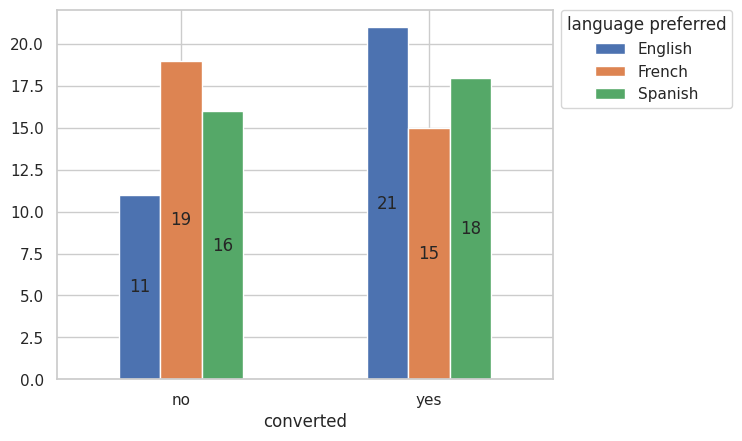

In [473]:
ct=pd.crosstab(df['converted'], df['language_preferred'])
ax=ct.plot(kind='bar',rot=0)
ax.legend(title='language preferred', bbox_to_anchor=(1, 1.02),
         loc='upper left')

for c in ax.containers:

    # set the bar label
    ax.bar_label(c, label_type='center')

The distribution of conversion status for English and French language users is not uniformly distributed. Let's perform the hypothesis test to check whether we have enough statistical evidence to say that the conversion status and preferred language are independent or not.

### Step 1: Define the null and alternative hypotheses

> $H_0:$ The converted status is independent of the preferred language. <br>
$H_a:$ The converted status is not independent of the preferred language.

### Step 2: Select Appropriate test

This is a problem of Chi-square test of independence, concerning the two independent categorical variables, converted status and preferred language.

### Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05.

### Step 4: Collect and prepare data

In [474]:
# create the contingency table showing the distribution of two categorical variables
contingency_table = pd.crosstab(df['converted'], df['language_preferred'])
contingency_table

language_preferred,English,French,Spanish
converted,,,
no,11,19,16
yes,21,15,18


### Step 5: Calculate the p-value

In [475]:
#import the required function
from scipy.stats import chi2_contingency
# use chi2_contingency() to find the p-value
chi_2, p_value, dof, exp_freq = chi2_contingency(contingency_table)
# print the p-value
print('The p-value is', p_value)

The p-value is 0.21298887487543447


### Step 6: Compare the p-value with $\alpha$

In [476]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.21298887487543447 is greater than the level of significance, we fail to reject the null hypothesis.


As the p-value 0.21298887487543447 is greater than the level of significance, we fail to reject the null hypothesis.

### Step 7:  Draw inference

Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we do not have enough statistical evidence to say that the converted status depends on the preferred language.

## 4. Is the time spent on the new page same for the different language users?

### Perform Visual Analysis

In [477]:
# create a new DataFrame for users who got served the new page
df_new = df[df['landing_page'] == 'new']

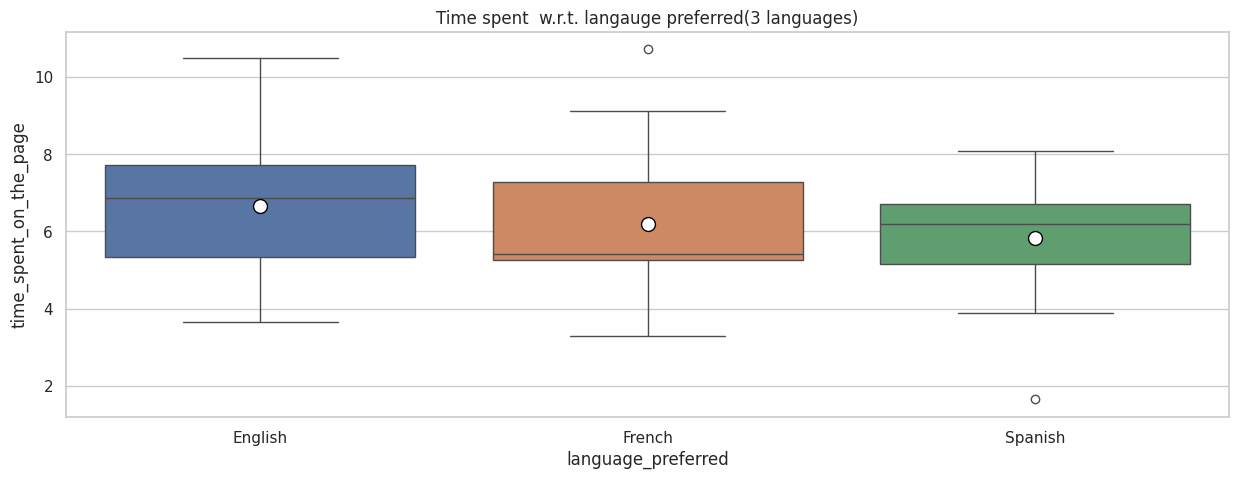

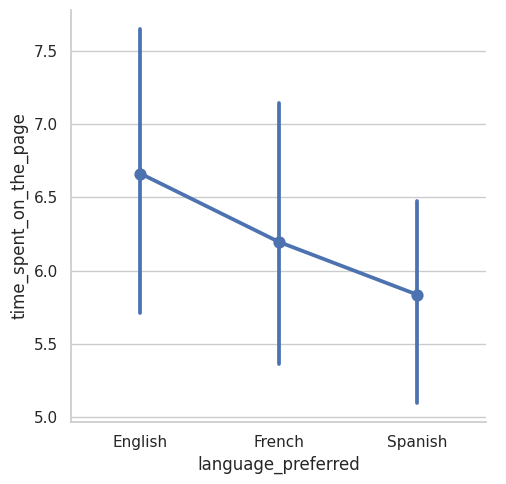

In [478]:
# write the code to visually plot the time spent on the new page for different language users

#sns.displot(data=df_new, x='time_spent_on_the_page', col='language_preferred', bins=10, col_wrap=3)
#fig, axes = plt.subplots(1, 2, figsize=(15, 5),sharey='row')
#plt.subplot(1, 3, 1)

# draw the boxplot for visualization
plt.figure(figsize=(15, 5))
sns.set_style('whitegrid');
sns.despine();
#plt.subplot(121)
a = sns.boxplot(x= "language_preferred", y = 'time_spent_on_the_page' , data = df_new, hue = 'language_preferred',showmeans=True,
            meanprops={"marker":"o",
                       "markerfacecolor":"white",
                       "markeredgecolor":"black",
                      "markersize":"10"})
a.set_title("Time spent  w.r.t. langauge preferred(3 languages)", fontsize=12)

#plt.subplot(122)
sns.catplot(x="language_preferred", y="time_spent_on_the_page", kind="point", data=df_new)

plt.tight_layout(w_pad=5)

In [479]:
# write the code to calculate the mean time spent on the new page for different language users
print(df_new.groupby("language_preferred")["time_spent_on_the_page"].mean())

language_preferred
English    6.663750
French     6.196471
Spanish    5.835294
Name: time_spent_on_the_page, dtype: float64


The mean time spent on the new page by English users is a bit higher than the mean time spent by French and Spanish users, but we need to test if this difference is statistically significant or not.

### Step 1: Define the null and alternative hypotheses

> $H_0:$ The mean times spent on the new page by English, French, and Spanish users are equal. <br>
$H_a:$ At least one of the mean times spent on the new page by English, French, and Spanish users is unequal.

### Step 2: Select Appropriate test

This is a problem, concerning three population means. One-way ANOVA could be the appropriate test here provided normality and equality of variance assumptions are verified.

* For testing of normality, Shapiro-Wilk’s test is applied to the response variable.

* For equality of variance, Levene test is applied to the response variable.

#### Shapiro-Wilk’s test

We will test the null hypothesis

>$H_0:$ Time spent on the new page follows a normal distribution

against the alternative hypothesis

>$H_a:$ Time spent on the new page does not follow a normal distribution

In [ ]:
# Assumption 1: Normality
# import the required function
from scipy.stats import shapiro

# find the p-value
w, p_value = shapiro(df_new['time_spent_on_the_page'])
print('The p-value is', p_value)

Since p-value of the test is very large than the 5% significance level, we fail to reject the null hypothesis that the response follows the normal distribution.

#### Levene’s test

We will test the null hypothesis

>$H_0$: All the population variances are equal

against the alternative hypothesis

>$H_a$: At least one variance is different from the rest

In [480]:
#Assumption 2: Homogeneity of Variance

from scipy.stats import levene
# create a subsetted data frame of the time spent on the new page by English language users
time_spent_English = df_new[df_new['language_preferred']=="English"]['time_spent_on_the_page']
# create subsetted data frames of the time spent on the new page by French and Spanish language users
time_spent_French =    df_new[df_new['language_preferred']=="French"]['time_spent_on_the_page']
time_spent_Spanish =    df_new[df_new['language_preferred']=="Spanish"]['time_spent_on_the_page']


statistic, p_value = levene( time_spent_English,
                             time_spent_French,
                             time_spent_Spanish)
# find the p-value
print('The p-value is', p_value)

The p-value is 0.46711357711340173


In [481]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.46711357711340173 is greater than the level of significance, we fail to reject the null hypothesis.


Since the p-value is large than the 5% significance level, we fail to reject the null hypothesis of homogeneity of variances.

### Step 3: Decide the significance level

As given in the problem statement, we select α = 0.05.

### Step 4: Collect and prepare data

* Let's test whether the assumptions are satisfied or not
The populations are normally distributed - Yes, the normality assumption is verified using the Shapiro-Wilk’s test.
* Samples are independent simple random samples - Yes, we are informed that the collected sample is a simple random sample.
* Population variances are equal - Yes, the homogeneity of variance assumption is verified using the Levene's test.

In [482]:
time_spent_English = df_new[df_new['language_preferred']=="English"]['time_spent_on_the_page']
time_spent_French = df_new[df_new['language_preferred']=="French"]['time_spent_on_the_page']
time_spent_Spanish = df_new[df_new['language_preferred']=="Spanish"]['time_spent_on_the_page']

### Step 5: Calculate the p-value

In [483]:
# import the required function
from scipy.stats import f_oneway
# find the p-value
test_stat, p_value = f_oneway(time_spent_English, time_spent_French, time_spent_Spanish)
# print the p-value
print('The p-value is', p_value)

The p-value is 0.43204138694325955


In [484]:
# print the conclusion based on p-value
if p_value < 0.05:
    print(f'As the p-value {p_value} is less than the level of significance, we reject the null hypothesis.')
else:
    print(f'As the p-value {p_value} is greater than the level of significance, we fail to reject the null hypothesis.')

As the p-value 0.43204138694325955 is greater than the level of significance, we fail to reject the null hypothesis.


### Step 7:  Draw inference

Since the p-value is greater than the 5% significance level, we fail to reject the null hypothesis. Hence, we do not have enough statistical evidence to say that the mean times spent on the new page by English, French, and Spanish users differ to any meaningful degree.

We can also do a Tukey HSD Multiple comparison test to validate all the mean time spent is same

In [485]:
#import the required function
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog = df_new['time_spent_on_the_page'], groups = df_new['language_preferred'], alpha = 0.05)
print(m_comp)



 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
English  French  -0.4673 0.7434 -2.0035  1.069  False
English Spanish  -0.8285 0.3995 -2.3647 0.7078  False
 French Spanish  -0.3612 0.8326  -1.874 1.1516  False
-----------------------------------------------------


- The reject columm is false for all language group that means all the means are same

* As the p-value is greater than the significance level, we can not reject the null hypothesis. Hence, we have statistical evidence to conclude that mean of time spent on English, French, Spanish langauage type is same. We can also do a Tukey HSD Multiple comparison test to validate all the maen time spent is same

## Conclusion and Recommendations

- The users spend more time on the new page.
  - This indicates that the outline & recommended content of the new page is more likely to keep customers engaged long enough to make a decision to subscribe

- The conversion rate for the new page is greater than the conversion rate of the old page
  - This indicates that the new page is more likely to gather new subscribers than the existing page

- The conversion status is independent of the preferred language

- The time spent on the new page does not differ with the language of the content
  - This indicates that irrespective of the language, the outline & recommended content of the new page are engaging

- It is recommended that the news company uses the new landing page to gather more subscribers
  - The business logic would be to design a page that people spend time in, conversion will follow